In [1]:
import os
import numpy as np
from PIL import Image
from scipy.spatial import distance
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


In [2]:
def load_and_preprocess_images(folder):
    images = []
    labels = []
    label_map = {}  
    label_counter = 0
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            if label not in label_map:
                label_map[label] = label_counter
                label_counter += 1
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                with Image.open(img_path) as img:
                    img_gray = img.convert('L')  # Convert to grayscale
                    images.append(np.array(img_gray).flatten())
                    labels.append(label_map[label])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

train_images, train_labels = load_and_preprocess_images('train')


In [3]:
def kNN_classify(k, X_train, y_train, X_test, dist_metric='euclidean'):
    if dist_metric == 'manhattan':
        dists = distance.cdist(X_test, X_train, 'cityblock')
    else:
        dists = distance.cdist(X_test, X_train, 'euclidean')
    
    y_pred = []
    for dist in dists:
        nearest_indices = np.argsort(dist)[:k]
        nearest_labels = y_train[nearest_indices]
        most_common = np.bincount(nearest_labels).argmax()
        y_pred.append(most_common)
    return np.array(y_pred)


In [4]:
def cross_validate_knn(k_values, X, y, distance_metrics=['euclidean', 'manhattan']):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = {metric: np.zeros(len(k_values)) for metric in distance_metrics}
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for dist_metric in distance_metrics:
            for i, k in enumerate(k_values):
                y_pred = kNN_classify(k, X_train, y_train, X_test, dist_metric)
                accuracy = np.mean(y_pred == y_test)
                accuracies[dist_metric][i] += accuracy
                
    for dist_metric in accuracies:
        accuracies[dist_metric] /= kf.get_n_splits()
    return accuracies

k_values = [1, 3, 5, 7, 9]
accuracies = cross_validate_knn(k_values, train_images, train_labels)


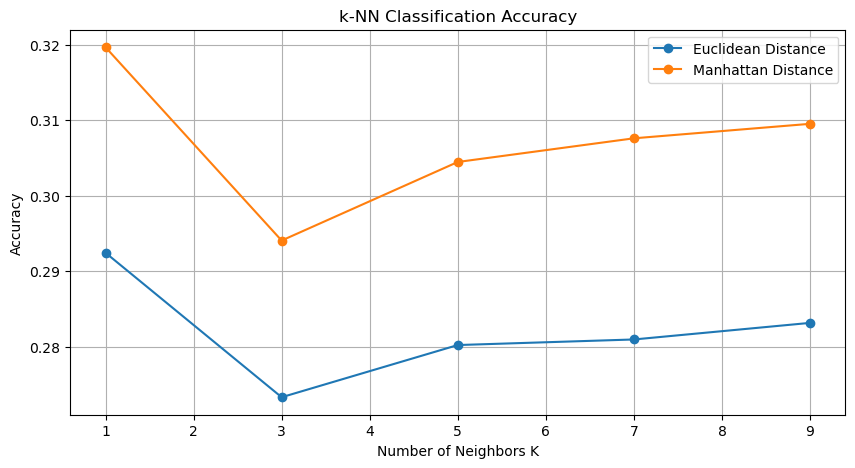

In [5]:
plt.figure(figsize=(10, 5))
for dist_metric, acc in accuracies.items():
    plt.plot(k_values, acc, marker='o', label=f'{dist_metric.capitalize()} Distance')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('k-NN Classification Accuracy')
plt.legend()
plt.grid(True)
plt.show()
